## Import necessary libraries:

In [197]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from IPython.display import display
import joblib
from tensorflow.keras.models import load_model
import joblib


## Load and preprocess the dataset:


In [198]:
# Load the dataset
df = pd.read_csv('training.csv')

# Drop rows with NULL or NaN values
df.dropna(inplace=True)

#Reset index
df = df.reset_index(drop=True)
display(df)

# Separate features and target variables
features = df[['Local_Queue', 'Transmission_Queue', 'Task_Arrival_Rate', 'Channel_Attenuation', 'Energy_Queue', 'MTCD_Transmission_Power']]
targets = df[['Alpha_1', 'Alpha_2', 'Alpha_3', 'Alpha_4','Local_Computation_Ratio', 'Offloading_Ratio']]

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

,Local_Queue,Transmission_Queue,MEC_Queue,Task_Arrival_Rate,Channel_Attenuation,Energy_Queue,MTCD_Transmission_Power,Alpha_1,Alpha_2,Alpha_3,Alpha_4,Throughput,Local_Computation_Ratio,Offloading_Ratio,Dropped_Ratio,Remaining_Energy,Tasks_Computed,Tasks_Dropped
0,9,14,0,92,0.709,0.001731,0.44,0.417456,0.512106,0.062327,0.415368,1.376863e+06,0.146730,0.851850,0.001421,0.003470,114.869285,0.130715
1,2,8,0,88,1.000,0.001973,0.58,0.475095,0.463831,0.055176,0.213601,1.174100e+06,0.108751,0.890349,0.000900,0.009297,97.920815,0.079185
2,4,13,0,76,1.000,0.000947,0.42,0.552979,0.375524,0.044412,0.439691,1.115966e+06,0.260745,0.739237,0.000018,0.009275,92.998599,0.001401
3,8,11,0,107,1.000,0.000915,0.50,0.251155,0.461690,0.054211,0.746760,1.511750e+06,0.303266,0.696636,0.000097,0.002613,125.989581,0.010419
4,7,6,0,97,0.568,0.001296,0.60,0.475094,0.464652,0.052996,0.466671,1.289194e+06,0.188433,0.798334,0.013233,0.001936,108.716434,1.283566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,3,1,0,87,1.000,0.001063,0.59,0.354424,0.303037,0.038563,0.635894,1.089393e+06,0.361428,0.637323,0.001249,0.005304,90.891363,0.108637
29224,9,10,0,73,1.000,0.001529,0.40,0.523708,0.360218,0.042773,0.471875,1.099597e+06,0.226848,0.770639,0.002513,0.009255,91.816558,0.183442
29225,9,8,0,89,1.000,0.001417,0.43,0.439020,0.498392,0.061390,0.256437,1.266689e+06,0.054947,0.942566,0.002486,0.007883,105.778714,0.221286
29226,5,5,0,84,0.466,0.000765,0.52,0.575421,0.373491,0.045644,0.411330,9.873332e+05,0.205719,0.724506,0.069775,0.001213,88.138884,5.861116


## Split the dataset into training and testing sets:

In [199]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, targets, test_size=0.2, random_state=42)


## Build and train the multi-target deep neural network:

In [200]:
import keras
from keras import layers
import keras.backend as K

# Custom loss function with constraints
def custom_loss_with_constraints(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    mse_loss = mse(y_true, y_pred)

    # Apply constraints penalty
    alpha_sum_1_to_3 = y_pred[:, 0] + y_pred[:, 1] + y_pred[:, 2]
    alpha_sum_1_to_4 = y_pred[:, 0] + y_pred[:, 3]
    alpha_sum_n_and_y = y_pred[:, 4] + y_pred[:, 5]

    constraint_penalty = K.mean(K.maximum(0.0, alpha_sum_1_to_3 - 1.0)) + \
                         K.mean(K.maximum(0.0, alpha_sum_1_to_4 - 1.0)) + \
                         K.mean(K.maximum(0.0, alpha_sum_n_and_y - 1.0))
    total_loss = mse_loss + constraint_penalty

    return total_loss


# Build the neural network model
modelTuned = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(targets.shape[1])  # Number of target variables
])

# Compile the model
modelTuned.compile(optimizer='adam', loss=custom_loss_with_constraints)
# modelTuned.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = modelTuned.fit(X_train, y_train, epochs=65, batch_size=32, validation_split=0.2)

Epoch 1/65
585/585 [==============================] - 12s 13ms/step - loss: 0.0463 - val_loss: 0.0146
Epoch 2/65
585/585 [==============================] - 6s 11ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 3/65
585/585 [==============================] - 7s 13ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 4/65
585/585 [==============================] - 6s 10ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 5/65
585/585 [==============================] - 7s 12ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 6/65
585/585 [==============================] - 6s 10ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 7/65
585/585 [==============================] - 7s 12ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 8/65
585/585 [==============================] - 6s 10ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 9/65
585/585 [==============================] - 8s 14ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 10/65
585/585 [==============================] - 6s 11ms/step - loss: 0.0135 - val_l

### Test loss




In [201]:
lossTuned = modelTuned.evaluate(X_test, y_test)
print(f"Test loss: {lossTuned}")

183/183 [==============================] - 1s 3ms/step - loss: 0.0133
Test loss: 0.013303778134286404


### Train loss

In [202]:
lossTuned = modelTuned.evaluate(X_train, y_train)
print(f"Train loss: {lossTuned}")

731/731 [==============================] - 3s 4ms/step - loss: 0.0124
Train loss: 0.012443303130567074


## Plot training and validation loss

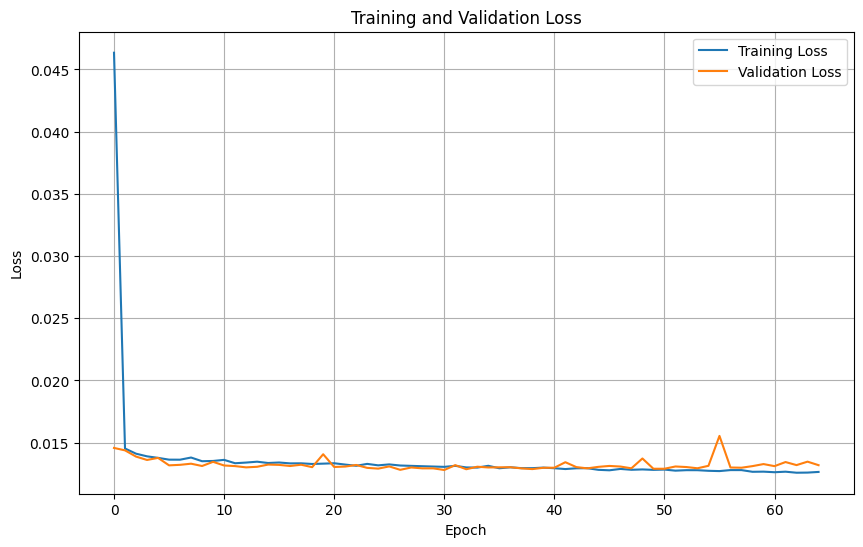

In [203]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Use the model to predict actions for known system states


### Load best model and scaler


In [204]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# Define your custom loss function
def custom_loss_with_constraints(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    mse_loss = mse(y_true, y_pred)

    # Apply constraints penalty
    alpha_sum_1_to_3 = y_pred[:, 0] + y_pred[:, 1] + y_pred[:, 2]
    alpha_sum_1_to_4 = y_pred[:, 0] + y_pred[:, 3]
    alpha_sum_n_and_y = y_pred[:, 4] + y_pred[:, 5]

    constraint_penalty = K.mean(K.maximum(0.0, alpha_sum_1_to_3 - 1.0)) + \
                         K.mean(K.maximum(0.0, alpha_sum_1_to_4 - 1.0)) + \
                         K.mean(K.maximum(0.0, alpha_sum_n_and_y - 1.0))
    total_loss = mse_loss + constraint_penalty

    return total_loss


# Load the scaler
scaler_filename = "scaler.pkl"
loaded_scaler = joblib.load(scaler_filename)

# Load the trained DNN model
model_filename = "trained_model.h5"

# Load the model within a custom_object_scope to register the custom loss function
with custom_object_scope({'custom_loss_with_constraints': custom_loss_with_constraints}):
    loaded_model = load_model(model_filename)

modelTuned = loaded_model
scaler = loaded_scaler

### Predict actions

In [205]:
# Predict Alpha values using the trained model
predicted_alphas = modelTuned.predict(scaled_features)

# Define the column names
column_names = ['Predicted_Alpha_1', 'Predicted_Alpha_2', 'Predicted_Alpha_3', 'Predicted_Alpha_4', 'Predicted_Local_Computation_Ratio', 'Predicted_Offloading_Ratio']

# Convert predicted_alphas to a DataFrame
df_predicted_alphas = pd.DataFrame(data=predicted_alphas, columns=column_names)

display(df_predicted_alphas)

914/914 [==============================] - 3s 3ms/step


,Predicted_Alpha_1,Predicted_Alpha_2,Predicted_Alpha_3,Predicted_Alpha_4,Predicted_Local_Computation_Ratio,Predicted_Offloading_Ratio
0,0.394908,0.501001,0.060127,0.415011,0.149771,0.844302
1,0.414404,0.387562,0.047523,0.462972,0.258277,0.734450
2,0.411255,0.362163,0.045271,0.487769,0.283959,0.710393
3,0.349996,0.511013,0.062766,0.506183,0.187207,0.804622
4,0.469724,0.455529,0.050539,0.441051,0.173261,0.804184
...,...,...,...,...,...,...
29223,0.451268,0.368339,0.049386,0.432477,0.233841,0.759330
29224,0.364418,0.351343,0.042376,0.569846,0.281500,0.712826
29225,0.374478,0.428527,0.051632,0.517476,0.215787,0.779994
29226,0.541673,0.395289,0.044556,0.352237,0.182364,0.760187


### Create a new table with the system state and predicted actions

In [206]:
df_p = pd.concat([features, df_predicted_alphas], axis=1)
display(df_p)

,Local_Queue,Transmission_Queue,Task_Arrival_Rate,Channel_Attenuation,Energy_Queue,MTCD_Transmission_Power,Predicted_Alpha_1,Predicted_Alpha_2,Predicted_Alpha_3,Predicted_Alpha_4,Predicted_Local_Computation_Ratio,Predicted_Offloading_Ratio
0,9,14,92,0.709,0.001731,0.44,0.394908,0.501001,0.060127,0.415011,0.149771,0.844302
1,2,8,88,1.000,0.001973,0.58,0.414404,0.387562,0.047523,0.462972,0.258277,0.734450
2,4,13,76,1.000,0.000947,0.42,0.411255,0.362163,0.045271,0.487769,0.283959,0.710393
3,8,11,107,1.000,0.000915,0.50,0.349996,0.511013,0.062766,0.506183,0.187207,0.804622
4,7,6,97,0.568,0.001296,0.60,0.469724,0.455529,0.050539,0.441051,0.173261,0.804184
...,...,...,...,...,...,...,...,...,...,...,...,...
29223,3,1,87,1.000,0.001063,0.59,0.451268,0.368339,0.049386,0.432477,0.233841,0.759330
29224,9,10,73,1.000,0.001529,0.40,0.364418,0.351343,0.042376,0.569846,0.281500,0.712826
29225,9,8,89,1.000,0.001417,0.43,0.374478,0.428527,0.051632,0.517476,0.215787,0.779994
29226,5,5,84,0.466,0.000765,0.52,0.541673,0.395289,0.044556,0.352237,0.182364,0.760187


### Calculate tasks dropped, throughput, tasks computed, remaining tasks and the remaining energy

In [207]:
# Create a new DataFrame to store the results
df_results = pd.DataFrame()

# Constants and column names
T = 0.01
J = 298.15
L = 0.7
b = 3
M = 0.001*10**9
Z = 5 * 10**6
Q = 100
R = 0.65 * 10**9
d = 10.0
e = 1500.0
q = 200
K = 1.38*10**(-23)
I = 3*10**8
U = 10**(-27)
g = 80
P = 'MTCD_Transmission_Power'
H = 'Channel_Attenuation'
B = 'Predicted_Alpha_2'
D = 'Predicted_Alpha_4'
a = 'Task_Arrival_Rate'
W = 'Transmission_Queue'
V = 'Local_Queue'
E = 'Energy_Queue'

df_results = df_p

# Loop through each row in df_p
for index, row in df_p.iterrows():
    Predicted_Throughput = (-(row['Local_Queue'] + row['Transmission_Queue'] + row['Task_Arrival_Rate']) * e * 8 + 2 * row['Predicted_Alpha_4'] * T * R / d + 2 * row['Predicted_Alpha_2'] * T * Z * np.log2(1 + row['MTCD_Transmission_Power'] * (row['Channel_Attenuation'] * row['Channel_Attenuation']) / (K * J * Z)))
    df_results.loc[index, 'Predicted_Throughput'] = Predicted_Throughput

for index, row in df_p.iterrows():
    Maximum_Local_Computation_Ratio = ((row[D] * T * R / (8 * d * e)) - row[V]) / row[a]
    Predicted_Local_Computation_Ratio = row['Predicted_Local_Computation_Ratio']

    if Maximum_Local_Computation_Ratio < Predicted_Local_Computation_Ratio:
      tasks_remaining_in_local_queue = (Predicted_Local_Computation_Ratio - Maximum_Local_Computation_Ratio) * row[a]
      df_results.loc[index, 'Tasks_Remaining_In_Local_Queue'] = tasks_remaining_in_local_queue
    else:
      df_results.loc[index, 'Tasks_Remaining_In_Local_Queue'] = 0

    Maximum_Offloading_Ratio = (row[B] * T * Z * np.log2(1 + row[P] * (row[H]**2) / (K * J * Z))/(8 * e) - row[W])/row[a]
    Predicted_Offloading_Ratio = row['Predicted_Offloading_Ratio']

    if Maximum_Offloading_Ratio < Predicted_Offloading_Ratio:
      tasks_remaining_in_offloading_queue = (Predicted_Offloading_Ratio - Maximum_Offloading_Ratio) * row[a]
      df_results.loc[index, 'Tasks_Remaining_In_Offloading_Queue'] = tasks_remaining_in_offloading_queue
    else:
      df_results.loc[index, 'Tasks_Remaining_In_Offloading_Queue'] = 0


for index, row in df_p.iterrows():
    Predicted_Dropped_Ratio = 1 - row['Predicted_Local_Computation_Ratio'] - row['Predicted_Offloading_Ratio']
    df_results.loc[index, 'Predicted_Dropped_Ratio'] = Predicted_Dropped_Ratio

for index, row in df_p.iterrows():
    Predicted_Tasks_Computed = (row['Predicted_Local_Computation_Ratio'] + row['Predicted_Offloading_Ratio']) * row[a] + row[V] + row[W] - (row['Tasks_Remaining_In_Offloading_Queue'] + row['Tasks_Remaining_In_Local_Queue'])
    df_results.loc[index, 'Predicted_Tasks_Computed'] = Predicted_Tasks_Computed

    Predicted_Tasks_Dropped = row['Predicted_Dropped_Ratio'] * row[a]
    df_results.loc[index, 'Predicted_Tasks_Dropped'] = Predicted_Tasks_Dropped

    Predicted_Remaining_Energy = (row['Predicted_Alpha_1'] * T * L * Q * (row[H]**2) * (I / (4 * g * np.pi * M))**b) + row[E] - U * row[D] * T * (R**3) - row[P] * row[B] * T
    df_results.loc[index, 'Predicted_Remaining_Energy'] = Predicted_Remaining_Energy

# Display the resulting DataFrame
display(df_results)

# Write the DataFrame to a CSV file
df_results.to_csv("results.csv", index=False)


,Local_Queue,Transmission_Queue,Task_Arrival_Rate,Channel_Attenuation,Energy_Queue,MTCD_Transmission_Power,Predicted_Alpha_1,Predicted_Alpha_2,Predicted_Alpha_3,Predicted_Alpha_4,Predicted_Local_Computation_Ratio,Predicted_Offloading_Ratio,Predicted_Throughput,Tasks_Remaining_In_Local_Queue,Tasks_Remaining_In_Offloading_Queue,Predicted_Dropped_Ratio,Predicted_Tasks_Computed,Predicted_Tasks_Dropped,Predicted_Remaining_Energy
0,9,14,92,0.709,0.001731,0.44,0.394908,0.501001,0.060127,0.415011,0.149771,0.844302,1.328327e+06,0.299169,1.308551,0.005928,112.846941,0.545339,0.002080
1,2,8,88,1.000,0.001973,0.58,0.414404,0.387562,0.047523,0.462972,0.258277,0.734450,1.157507e+06,0.000000,0.479794,0.007273,96.880175,0.640031,0.006162
2,4,13,76,1.000,0.000947,0.42,0.411255,0.362163,0.045271,0.487769,0.283959,0.710393,1.119395e+06,0.000000,0.269228,0.005649,92.301462,0.429310,0.005737
3,8,11,107,1.000,0.000915,0.50,0.349996,0.511013,0.062766,0.506183,0.187207,0.804622,1.418324e+06,0.612871,2.415950,0.008171,122.096832,0.874347,0.003480
4,7,6,97,0.568,0.001296,0.60,0.469724,0.455529,0.050539,0.441051,0.173261,0.804184,1.216570e+06,0.000000,2.205700,0.022556,105.606407,2.187892,0.000171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,3,1,87,1.000,0.001063,0.59,0.451268,0.368339,0.049386,0.432477,0.233841,0.759330,1.116884e+06,0.000000,0.000000,0.006829,90.405867,0.594133,0.006097
29224,9,10,73,1.000,0.001529,0.40,0.364418,0.351343,0.042376,0.569846,0.281500,0.712826,1.187781e+06,0.000000,0.000000,0.005674,91.585815,0.414185,0.005338
29225,9,8,89,1.000,0.001417,0.43,0.374478,0.428527,0.051632,0.517476,0.215787,0.779994,1.296897e+06,0.175133,0.000000,0.004219,105.449415,0.375452,0.005119
29226,5,5,84,0.466,0.000765,0.52,0.541673,0.395289,0.044556,0.352237,0.182364,0.760187,1.002759e+06,1.239100,0.000000,0.057449,87.935186,4.825715,-0.000070


## Clean up valid results

Determine how the model would perform if these edge cases were implemented

In [208]:
# Drop rows with NULL or NaN values
df_results.dropna(inplace=True)

# Restrict tasks computed to the theoretical maximum when valid (When there are negative tasks dropped and the remaining energy is greater then zero)
for index, row in df_results.iterrows():
  if (row['Predicted_Tasks_Dropped'] < 0) & (row['Predicted_Remaining_Energy'] > 0):
    df_results.loc[index,'Predicted_Tasks_Dropped'] = 0.0
    df_results.loc[index,'Predicted_Dropped_Ratio'] = 0.0
    df_results.loc[index, 'Predicted_Tasks_Computed'] = row[V] + row[W] + row[a] - (row['Tasks_Remaining_In_Offloading_Queue'] + row['Tasks_Remaining_In_Local_Queue'])
    df_results.loc[index, 'Predicted_Throughput'] = row['Predicted_Throughput'] - abs(row["Predicted_Tasks_Dropped"]) * e * 8 #Negative tasks effect the computation rate

# Remove surplus tasks and increase the energy (When there are Negative tasks dropped but also negative renmaining energy)
for index, row in df_results.iterrows():
  if (row['Predicted_Tasks_Dropped'] < 0) & (row['Predicted_Remaining_Energy'] < 0):
     true_remaining_energy = row['MTCD_Transmission_Power'] * row['Predicted_Tasks_Dropped'] * e * 8 / (Z * np.log2(1 + row['MTCD_Transmission_Power'] * (row['Channel_Attenuation'] * row['Channel_Attenuation']) / (K * J * Z))) + row['Predicted_Remaining_Energy']
     df_results.loc[index,'Predicted_Tasks_Dropped'] = 0.0
     df_results.loc[index, 'Predicted_Remaining_Energy'] = true_remaining_energy
     df_results.loc[index, 'Predicted_Throughput'] = row['Predicted_Throughput'] - abs(row["Predicted_Tasks_Dropped"]) * e * 8 #Negative tasks effect the computation rate

# Drop additional tasks if there wasn't enough energy to compute them (Positive tasks dropped but negative remaining energy)
for index, row in df_results.iterrows():
  if (row['Predicted_Tasks_Dropped'] > 0) & (row['Predicted_Remaining_Energy'] < 0):
    if row['Predicted_Alpha_2'] > row['Predicted_Alpha_4']:
     new_dropped = row['Predicted_Remaining_Energy'] * (Z * np.log2(1 + row['MTCD_Transmission_Power'] * (row['Channel_Attenuation'] * row['Channel_Attenuation']) / (K * J * Z)))/(row['MTCD_Transmission_Power'] * e * 8) + row['Predicted_Tasks_Dropped']
     df_results.loc[index,'Predicted_Tasks_Dropped'] = new_dropped
     df_results.loc[index, 'Predicted_Remaining_Energy'] = 0.0

# Delete rows that don't meet the alpha constraint
df_results = df_results[
    (df_results['Predicted_Alpha_1'] + df_results['Predicted_Alpha_2'] + df_results['Predicted_Alpha_3'] <= 1) &
    (df_results['Predicted_Alpha_1'] + df_results['Predicted_Alpha_4'] <= 1)
]


In [209]:
display(df_results)

,Local_Queue,Transmission_Queue,Task_Arrival_Rate,Channel_Attenuation,Energy_Queue,MTCD_Transmission_Power,Predicted_Alpha_1,Predicted_Alpha_2,Predicted_Alpha_3,Predicted_Alpha_4,Predicted_Local_Computation_Ratio,Predicted_Offloading_Ratio,Predicted_Throughput,Tasks_Remaining_In_Local_Queue,Tasks_Remaining_In_Offloading_Queue,Predicted_Dropped_Ratio,Predicted_Tasks_Computed,Predicted_Tasks_Dropped,Predicted_Remaining_Energy
0,9,14,92,0.709,0.001731,0.44,0.394908,0.501001,0.060127,0.415011,0.149771,0.844302,1.328327e+06,0.299169,1.308551,0.005928,112.846941,0.545339,0.002080
1,2,8,88,1.000,0.001973,0.58,0.414404,0.387562,0.047523,0.462972,0.258277,0.734450,1.157507e+06,0.000000,0.479794,0.007273,96.880175,0.640031,0.006162
2,4,13,76,1.000,0.000947,0.42,0.411255,0.362163,0.045271,0.487769,0.283959,0.710393,1.119395e+06,0.000000,0.269228,0.005649,92.301462,0.429310,0.005737
3,8,11,107,1.000,0.000915,0.50,0.349996,0.511013,0.062766,0.506183,0.187207,0.804622,1.418324e+06,0.612871,2.415950,0.008171,122.096832,0.874347,0.003480
4,7,6,97,0.568,0.001296,0.60,0.469724,0.455529,0.050539,0.441051,0.173261,0.804184,1.216570e+06,0.000000,2.205700,0.022556,105.606407,2.187892,0.000171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,3,1,87,1.000,0.001063,0.59,0.451268,0.368339,0.049386,0.432477,0.233841,0.759330,1.116884e+06,0.000000,0.000000,0.006829,90.405867,0.594133,0.006097
29224,9,10,73,1.000,0.001529,0.40,0.364418,0.351343,0.042376,0.569846,0.281500,0.712826,1.187781e+06,0.000000,0.000000,0.005674,91.585815,0.414185,0.005338
29225,9,8,89,1.000,0.001417,0.43,0.374478,0.428527,0.051632,0.517476,0.215787,0.779994,1.296897e+06,0.175133,0.000000,0.004219,105.449415,0.375452,0.005119
29226,5,5,84,0.466,0.000765,0.52,0.541673,0.395289,0.044556,0.352237,0.182364,0.760187,1.002759e+06,1.239100,0.000000,0.057449,87.935186,2.461697,0.000000


## Clean up optimal predictions dataset so we can compare results

In [210]:
# Get the index values that have not been dropped in df_results
remaining_indexes = df_results.index

# Extract the corresponding entries in df
df_cleaned = df.loc[remaining_indexes]


display(df_cleaned)

# Restrict tasks computed to the maximum when valid
for index, row in df_cleaned.iterrows():
  if (row['Tasks_Dropped'] < 0.001):
    df_cleaned.loc[index,'Tasks_Dropped'] = 0.0
    df_cleaned.loc[index,'Dropped_Ratio'] = 0.0
    df_cleaned.loc[index, 'Tasks_Computed'] = row[V] + row[W] + row[a]
    df_cleaned.loc[index, 'Throughput'] = (row[V] + row[W] + row[a]) * e * 8

display(df_cleaned)

,Local_Queue,Transmission_Queue,MEC_Queue,Task_Arrival_Rate,Channel_Attenuation,Energy_Queue,MTCD_Transmission_Power,Alpha_1,Alpha_2,Alpha_3,Alpha_4,Throughput,Local_Computation_Ratio,Offloading_Ratio,Dropped_Ratio,Remaining_Energy,Tasks_Computed,Tasks_Dropped
0,9,14,0,92,0.709,0.001731,0.44,0.417456,0.512106,0.062327,0.415368,1.376863e+06,0.146730,0.851850,0.001421,0.003470,114.869285,0.130715
1,2,8,0,88,1.000,0.001973,0.58,0.475095,0.463831,0.055176,0.213601,1.174100e+06,0.108751,0.890349,0.000900,0.009297,97.920815,0.079185
2,4,13,0,76,1.000,0.000947,0.42,0.552979,0.375524,0.044412,0.439691,1.115966e+06,0.260745,0.739237,0.000018,0.009275,92.998599,0.001401
3,8,11,0,107,1.000,0.000915,0.50,0.251155,0.461690,0.054211,0.746760,1.511750e+06,0.303266,0.696636,0.000097,0.002613,125.989581,0.010419
4,7,6,0,97,0.568,0.001296,0.60,0.475094,0.464652,0.052996,0.466671,1.289194e+06,0.188433,0.798334,0.013233,0.001936,108.716434,1.283566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,3,1,0,87,1.000,0.001063,0.59,0.354424,0.303037,0.038563,0.635894,1.089393e+06,0.361428,0.637323,0.001249,0.005304,90.891363,0.108637
29224,9,10,0,73,1.000,0.001529,0.40,0.523708,0.360218,0.042773,0.471875,1.099597e+06,0.226848,0.770639,0.002513,0.009255,91.816558,0.183442
29225,9,8,0,89,1.000,0.001417,0.43,0.439020,0.498392,0.061390,0.256437,1.266689e+06,0.054947,0.942566,0.002486,0.007883,105.778714,0.221286
29226,5,5,0,84,0.466,0.000765,0.52,0.575421,0.373491,0.045644,0.411330,9.873332e+05,0.205719,0.724506,0.069775,0.001213,88.138884,5.861116


,Local_Queue,Transmission_Queue,MEC_Queue,Task_Arrival_Rate,Channel_Attenuation,Energy_Queue,MTCD_Transmission_Power,Alpha_1,Alpha_2,Alpha_3,Alpha_4,Throughput,Local_Computation_Ratio,Offloading_Ratio,Dropped_Ratio,Remaining_Energy,Tasks_Computed,Tasks_Dropped
0,9,14,0,92,0.709,0.001731,0.44,0.417456,0.512106,0.062327,0.415368,1.376863e+06,0.146730,0.851850,0.001421,0.003470,114.869285,0.130715
1,2,8,0,88,1.000,0.001973,0.58,0.475095,0.463831,0.055176,0.213601,1.174100e+06,0.108751,0.890349,0.000900,0.009297,97.920815,0.079185
2,4,13,0,76,1.000,0.000947,0.42,0.552979,0.375524,0.044412,0.439691,1.115966e+06,0.260745,0.739237,0.000018,0.009275,92.998599,0.001401
3,8,11,0,107,1.000,0.000915,0.50,0.251155,0.461690,0.054211,0.746760,1.511750e+06,0.303266,0.696636,0.000097,0.002613,125.989581,0.010419
4,7,6,0,97,0.568,0.001296,0.60,0.475094,0.464652,0.052996,0.466671,1.289194e+06,0.188433,0.798334,0.013233,0.001936,108.716434,1.283566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,3,1,0,87,1.000,0.001063,0.59,0.354424,0.303037,0.038563,0.635894,1.089393e+06,0.361428,0.637323,0.001249,0.005304,90.891363,0.108637
29224,9,10,0,73,1.000,0.001529,0.40,0.523708,0.360218,0.042773,0.471875,1.099597e+06,0.226848,0.770639,0.002513,0.009255,91.816558,0.183442
29225,9,8,0,89,1.000,0.001417,0.43,0.439020,0.498392,0.061390,0.256437,1.266689e+06,0.054947,0.942566,0.002486,0.007883,105.778714,0.221286
29226,5,5,0,84,0.466,0.000765,0.52,0.575421,0.373491,0.045644,0.411330,9.873332e+05,0.205719,0.724506,0.069775,0.001213,88.138884,5.861116


## Compare predictions to the optimal solution


In [212]:
average_optimal_computation_rate = df_cleaned["Throughput"].mean()
print("Average throughput of the optimal solution determined by brute forcing all possible combinations:", average_optimal_computation_rate)

average_predicted_computation_rate = df_results["Predicted_Throughput"].mean()
print("Average throughput for DNN predictions:", average_predicted_computation_rate)


stats = (average_predicted_computation_rate/average_optimal_computation_rate) * 100

print("Final verdict: Our DNN model reaches ", stats, "% of the optimal solution")


Average throughput of the optimal solution determined by brute forcing all possible combinations: 1163776.8808959578
Average throughput for DNN predictions: 1150647.0839982093
Final verdict: Our DNN model reaches  98.87179431785582 % of the optimal solution


## Compare results to random guessing


In [213]:
# Load the dataset
df_rand = pd.read_csv('randomGuessing.csv')

average_random_computation_rate = df_rand["Computation_Rate"].mean()
print("Average throughput for random guesses:", average_random_computation_rate)


stats = (average_random_computation_rate/average_optimal_computation_rate) * 100
stats2 = ((average_predicted_computation_rate-average_random_computation_rate)/average_random_computation_rate) * 100

print("Final verdict: Random guessing reaches ", stats, "% of the optimal solution")
print("Final verdict: Our DNN model achieves a ", stats2, "% improvement over random guessing")


Average throughput for random guesses: 618833.4425624569
Final verdict: Random guessing reaches  53.17457776666221 % of the optimal solution
Final verdict: Our DNN model achieves a  85.93809009959543 % improvement over random guessing


## Export the learned model to an enviroment simulation with multiple MTCD's and frames



In [214]:
import numpy as np
import pandas as pd
from scipy.stats import rayleigh, expon
from sympy import symbols
from scipy.optimize import minimize

# Constants and column names
T = 0.01
J = 298.15
L = 0.7
b = 3
M = 0.001*10**9
Z = 5 * 10**6
Q = 100
R = 0.65 * 10**9
d = 10.0
e = 1500.0
q = 200
K = 1.38*10**(-23)
I = 3*10**8
U = 10**(-27)
g = 80
# P = 'MTCD_Transmission_Power'
# a = 'Task_Arrival_Rate'
# W = 'Transmission_Queue'
# V = 'Local_Queue'
# E = 'Energy_Queue'

num_frames = 250
num_mtcd = 3

#Define result arrays
Local_remaining = np.zeros((num_mtcd, num_frames-1))
Offloading_remaining = np.zeros((num_mtcd, num_frames-1))
Energy_queue = np.zeros((num_mtcd, num_frames-1))
Tasks_dropped = np.zeros((num_mtcd, num_frames-1))
Tasks_computed = np.zeros((num_mtcd, num_frames-1))
Objective = np.zeros((num_mtcd, num_frames-1))
Optimal = np.zeros((num_mtcd, num_frames-1))

#MTCD Loop

for j in range(0,num_mtcd):

  E = np.random.rayleigh(scale=0.001, size=1) # Generate energy in energy queue using Rayleigh distribution
  V = np.random.randint(0, 7, size=1) # Existing tasks in the local computation queue (Rayleigh distribution)
  W = np.random.randint(0, 7, size=1) # Existing tasks in the transmission queue (Rayleigh distribution)
  # Tasks
  lambda_val = 90
  a = np.random.poisson(lambda_val, num_frames)
  # NOMA Transmission power
  lower_bound = 40
  upper_bound = 60
  P = np.random.randint(lower_bound, upper_bound + 1, size=num_frames) / 100
  # Generate channel gain using an exponential random variable
  averageHSquared = 0.7
  rateParameter = 1 / averageHSquared
  H = np.sqrt(np.minimum(expon.rvs(scale=1/rateParameter, size=num_frames), 1))
  # Tasks dropped
  Predicted_Tasks_Dropped = 0;

# Frame Loop

  for i in range(0,num_frames-1):
    #Features
    # Constructing features as a 2D array
    features = np.column_stack((V, W, a[i], H[i], E, P[i]))
    scaled_features = scaler.fit_transform(features)

    predicted_alphas = modelTuned.predict(scaled_features)
    A1 = predicted_alphas[0][0]
    A2 = predicted_alphas[0][1]
    A3 = predicted_alphas[0][2]
    A4 = predicted_alphas[0][3]
    pre_comp_ratio = predicted_alphas[0][4]
    pre_off_ratio = predicted_alphas[0][5]

    a[i] = a[i] + Predicted_Tasks_Dropped

    #Perform necessary calculations
    predicted_throughput = (-(V + W + a[i]) * e * 8 + 2 * A4 * T * R / d + \
                        2 * A2 * T * Z * np.log2(1 + P[i] * (H[i] * H[i]) / (K * J * Z)))

    Maximum_Local_Computation_Ratio = ((A4 * T * R / (8 * d * e)) - V) / a[i]
    if Maximum_Local_Computation_Ratio < pre_comp_ratio:
        tasks_remaining_in_local_queue = (pre_comp_ratio - Maximum_Local_Computation_Ratio) * a[i]
    else:
        tasks_remaining_in_local_queue = 0

    Maximum_Offloading_Ratio = (A2 * T * Z * np.log2(1 + P[i] * (H[i]**2) / (K * J * Z))/(8 * e) - W)/a[i]
    if Maximum_Offloading_Ratio < pre_off_ratio:
        tasks_remaining_in_offloading_queue = (pre_off_ratio - Maximum_Offloading_Ratio) * a[i]
    else:
        tasks_remaining_in_offloading_queue = 0

    Predicted_Dropped_Ratio = 1 - pre_comp_ratio - pre_off_ratio
    Predicted_Tasks_Computed = (pre_comp_ratio + pre_off_ratio) * a[i] + V + W - (tasks_remaining_in_local_queue + tasks_remaining_in_offloading_queue)
    Predicted_Tasks_Dropped = Predicted_Dropped_Ratio * a[i]
    Predicted_Remaining_Energy = (A1 * T * L * Q * (H[i]**2) * (I / (4 * g * np.pi * M))**b) + E - U * A4 * T * (R**3) - P[i] * A2 * T

    # Restrict tasks computed to the theoretical maximum when valid (When there are negative tasks dropped and the remaining energy is greater then zero)
    if (Predicted_Tasks_Dropped < 0) & (Predicted_Remaining_Energy > 0):
      Predicted_Tasks_Dropped = 0.0
      Predicted_Dropped_Ratio = 0.0
      Predicted_Tasks_Computed = V + W + a[i] - (tasks_remaining_in_local_queue + tasks_remaining_in_offloading_queue)
      predicted_throughput = predicted_throughput - abs(Predicted_Tasks_Dropped) * e * 8

    # Remove surplus tasks and increase the energy (When there are Negative tasks dropped but also negative renmaining energy)
    if (Predicted_Tasks_Dropped < 0) & (Predicted_Remaining_Energy < 0):
      true_remaining_energy = P[i] * Predicted_Tasks_Dropped * e * 8 / (Z * np.log2(1 + P[i] * (H[i] * H[i]) / (K * J * Z))) + Predicted_Remaining_Energy
      Predicted_Tasks_Dropped = 0.0
      Predicted_Remaining_Energy = true_remaining_energy
      predicted_throughput = predicted_throughput - abs(Predicted_Tasks_Dropped) * e * 8

    # Drop additional tasks if there wasn't enough energy to compute them (Positive tasks dropped but negative remaining energy)
    if (Predicted_Tasks_Dropped > 0) & (Predicted_Remaining_Energy < 0):
      if A2 > A4:
        new_dropped = Predicted_Remaining_Energy * (Z * np.log2(1 + P[i] * (H[i]*H[i]) / (K * J * Z)))/(P[i] * e * 8) + Predicted_Tasks_Dropped
        Predicted_Tasks_Dropped = new_dropped
        Predicted_Remaining_Energy = 0.0

    #optimal_ratio = predicted_throughput/((a[i] + V + W)*(8 * e))
    optimal_ratio = Predicted_Tasks_Computed/(a[i] + V + W)

    #Results to be passed onto the next frame
    V = tasks_remaining_in_local_queue
    W = tasks_remaining_in_offloading_queue
    E = Predicted_Remaining_Energy

    #Stores results
    Local_remaining[j][i] = tasks_remaining_in_local_queue
    Offloading_remaining[j][i] = tasks_remaining_in_offloading_queue
    Energy_queue[j][i] = Predicted_Remaining_Energy
    Tasks_dropped[j][i] = Predicted_Tasks_Dropped
    Tasks_computed[j][i] = Predicted_Tasks_Computed
    Objective[j][i] = predicted_throughput
    Optimal[j][i] = optimal_ratio


1/1 [==============================] - 0s 31ms/step


### Plot results


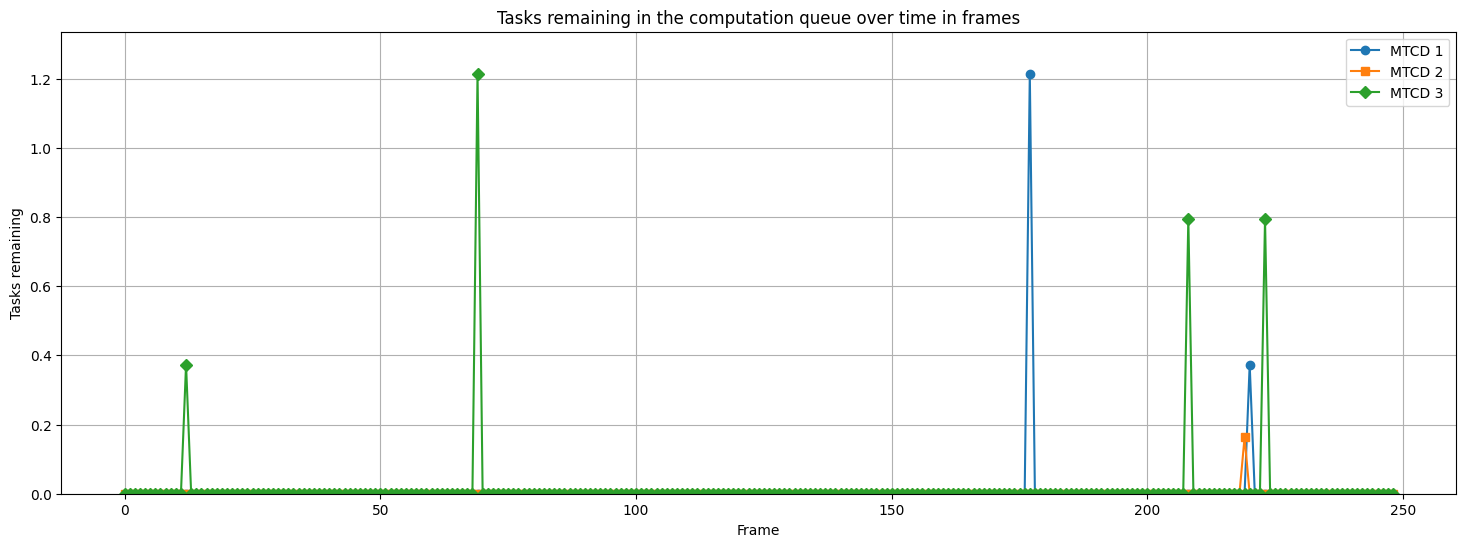

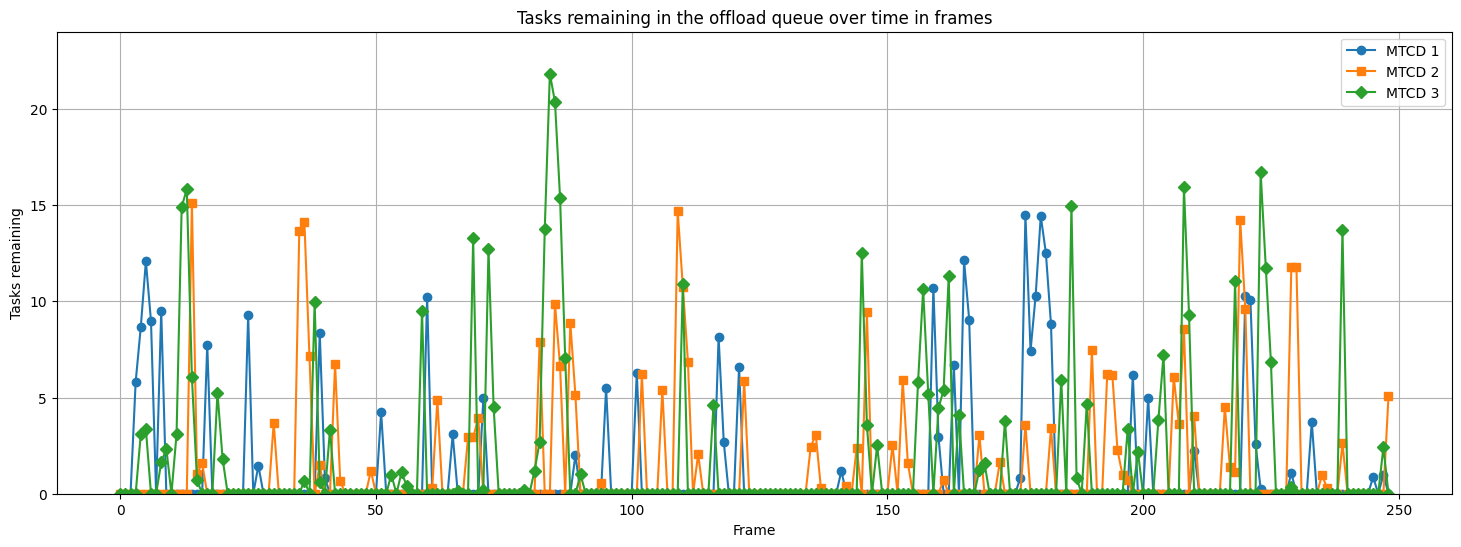

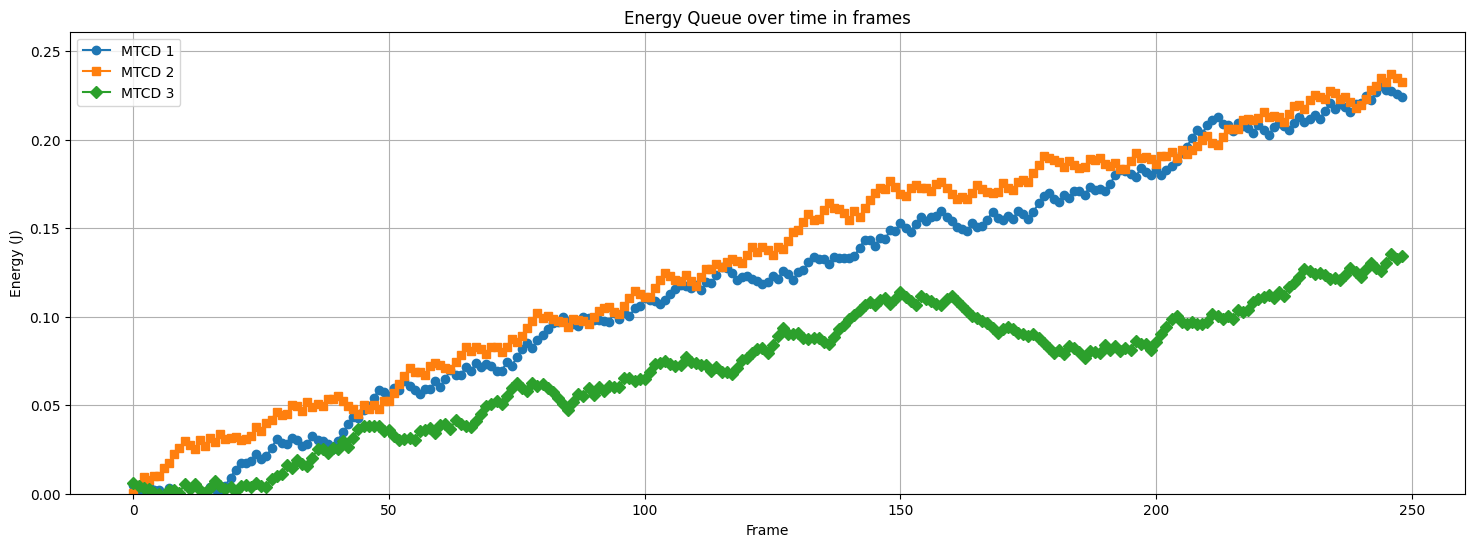

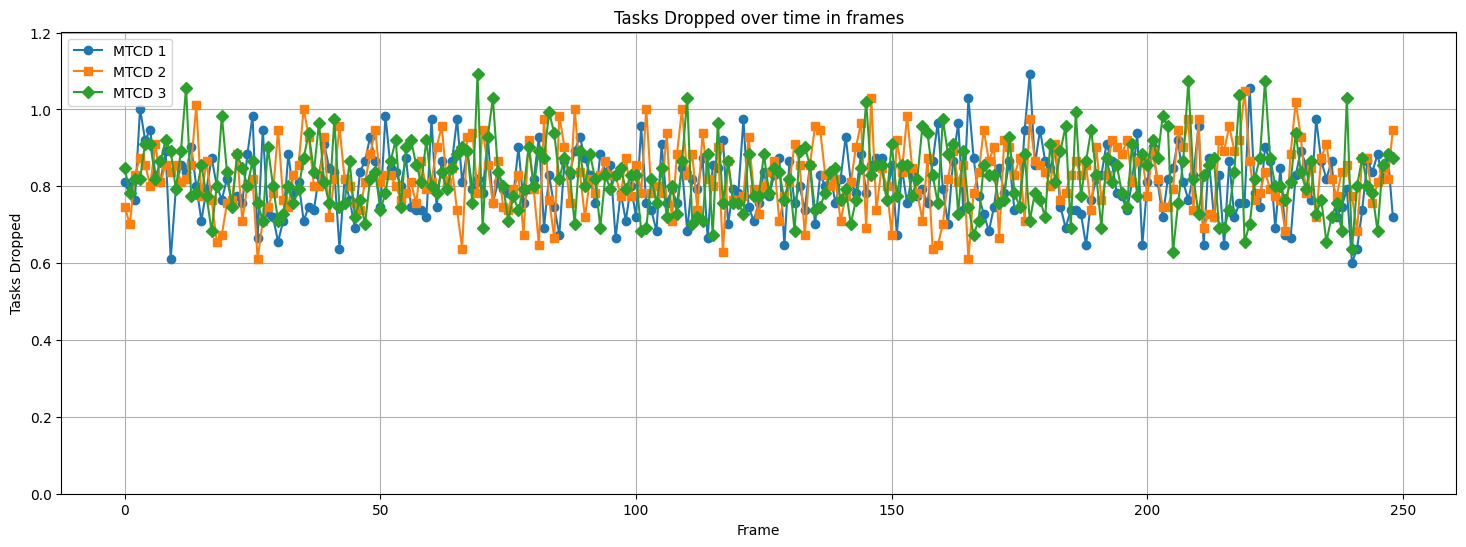

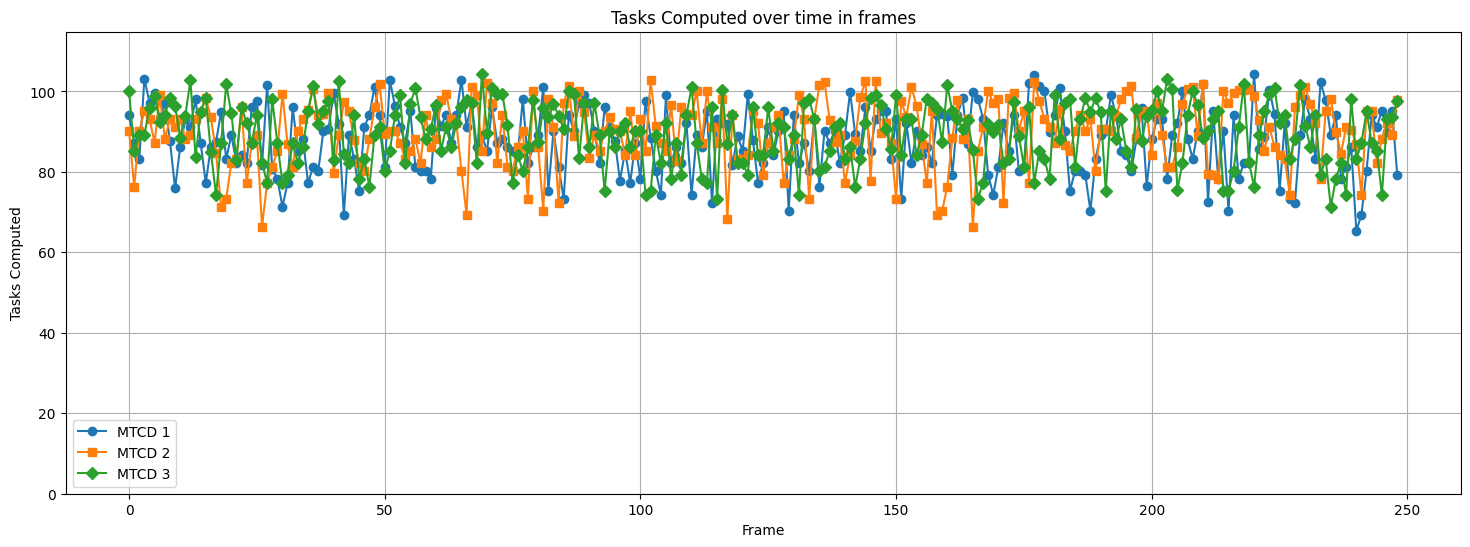

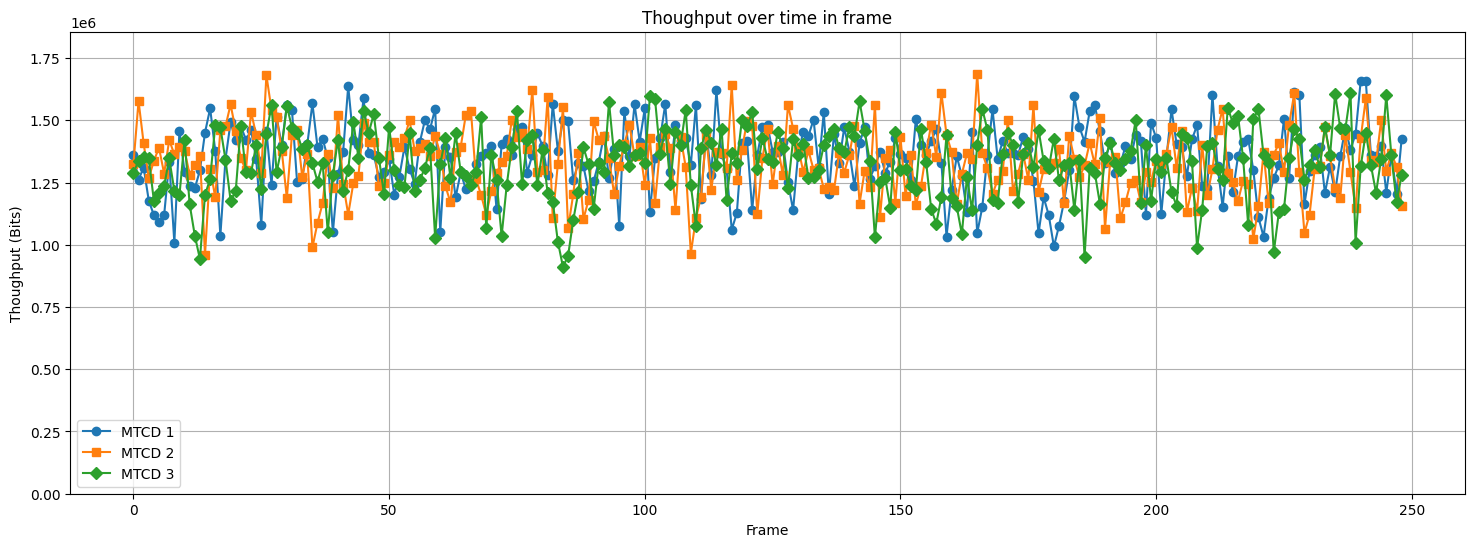

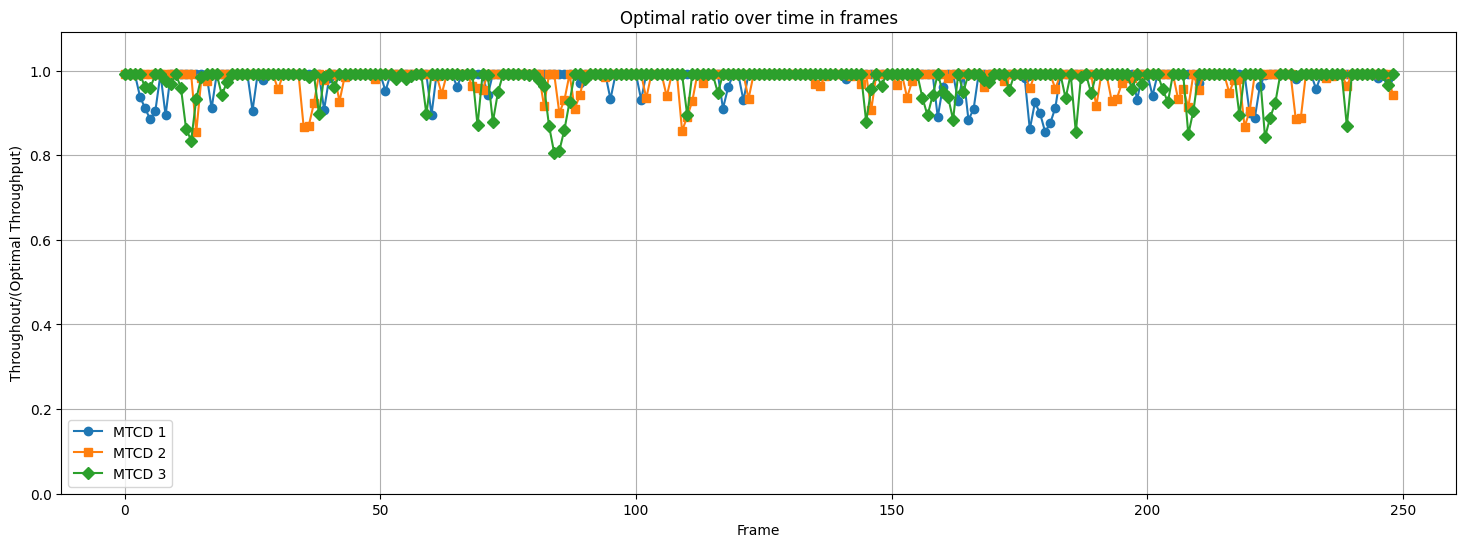

In [215]:
# Arrays of 2D arrays for easy iteration
array_list = [Local_remaining, Offloading_remaining, Energy_queue, Tasks_dropped, Tasks_computed, Objective, Optimal]
array_names = ["Tasks remaining in the computation queue over time in frames", "Tasks remaining in the offload queue over time in frames", "Energy Queue over time in frames", "Tasks Dropped over time in frames", "Tasks Computed over time in frames", "Thoughput over time in frame", "Optimal ratio over time in frames"]
x_names = ["Tasks remaining", "Tasks remaining", "Energy (J)", "Tasks Dropped", "Tasks Computed", "Thoughput (Bits)", "Throughout/(Optimal Throughput)"]

# Define line styles and markers
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', '*', 'x']

# Plotting
for i, array in enumerate(array_list):
    rows, cols = array.shape

    plt.figure(figsize=(18, 6))
    for j in range(rows):
        # plt.plot(range(cols), array[j], linestyle=line_styles[j % len(line_styles)],
        #          marker=markers[j % len(markers)], label=f'MTCD {j + 1}')
        plt.plot(range(cols), array[j],marker=markers[j % len(markers)], label=f'MTCD {j + 1}')

    plt.title(f'{array_names[i]}')
    plt.xlabel('Frame')
    plt.ylabel(x_names[i])
    plt.legend()
    plt.grid()

    ymin = 0
    ymax = 1.1*np.max(array)
    plt.ylim(ymin, ymax)

    plt.show()

 ### Save model and scaler


In [216]:
import joblib

# # Save the scaler
# scaler_filename = "scaler.pkl"
# joblib.dump(scaler, scaler_filename)

# # Save the trained DNN model
# model_filename = "trained_model.h5"  # You can use a different extension if you're using a different model format
# modelTuned.save(model_filename)
